In [18]:
# =============================================================================
# Install and Import Required Libraries
# =============================================================================

# !pip install scikit-learn opencv-python matplotlib seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import os
from pathlib import Path
import pickle
import time

print("All libraries imported successfully!")

All libraries imported successfully!


In [19]:
# =============================================================================
# Dataset Path Configuration
# =============================================================================

# Dataset path 
DATA_PATH = "/Users/mahendrapal/Documents/semester7/DSP project/DSP_project_code/1_3/raw-img"

In [20]:
# =============================================================================
# Define the RFBaseline Class
# =============================================================================

class RFBaseline:

    def __init__(self, img_size=(64, 64), n_estimators=100, random_state=42):
        """
        Initialize the RF Baseline classifier

        Args:
            img_size: Tuple of (height, width) to resize images
            n_estimators: Number of trees in random forest
            random_state: Random seed for reproducibility
        """
        self.img_size = img_size
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1,  # Use all CPU cores
            verbose=1
        )
        self.scaler = StandardScaler()
        self.class_names = None
        self.data_splits = None

    def load_and_split_data(self, data_path, test_split=0.20, val_split=0.15, random_state=42):

        # Get class names from folder names
        all_folders = sorted([d for d in os.listdir(data_path)
                             if os.path.isdir(os.path.join(data_path, d))])

        print(f"\nLoading data from: {data_path}")
        print(f"Folders found: {all_folders}")

        all_images = []
        all_labels = []
        class_counts = []
        valid_classes = []

        for class_idx, class_name in enumerate(all_folders):
            class_path = os.path.join(data_path, class_name)

            # Debug: Check what files are in the folder
            all_files = os.listdir(class_path)
            print(f"\n{class_name} folder contents: {len(all_files)} total files")

            # Check different image extensions
            image_files = []
            for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
                matching = [f for f in all_files if f.endswith(ext)]
                if matching:
                    print(f"  Found {len(matching)} files with extension {ext}")
                    image_files.extend(matching)

            # Also try case-insensitive matching
            if len(image_files) == 0:
                image_files = [f for f in all_files
                              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
                if image_files:
                    print(f"  Found {len(image_files)} images with case-insensitive search")

            print(f"Loading {class_name}: {len(image_files)} images")

            if len(image_files) == 0:
                print(f"  ⚠️  WARNING: No images found in {class_path}")
                print(f"  Sample files in folder: {all_files[:5]}")
                continue

            valid_classes.append(class_name)
            class_image_count = 0
            failed_count = 0

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)

                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    failed_count += 1
                    if failed_count <= 3:  
                        print(f"  ⚠️  Failed to read: {img_file}")
                    continue

                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize image
                img = cv2.resize(img, self.img_size)

                # Normalize to [0, 1]
                img = img.astype(np.float32) / 255.0

                # Flatten image
                img_flat = img.flatten()

                all_images.append(img_flat)
                all_labels.append(len(valid_classes) - 1)
                class_image_count += 1

            if failed_count > 0:
                print(f"  Failed to load {failed_count} images from {class_name}")

            class_counts.append(class_image_count)
            print(f"  Successfully loaded: {class_image_count} images")

        # Update class_names to only include classes with images
        self.class_names = valid_classes

        if len(self.class_names) == 0:
            raise ValueError("No images found in any class folder! Please check your dataset path.")

        all_images = np.array(all_images)
        all_labels = np.array(all_labels)

        print(f"\n{'='*50}")
        print(f"DATA LOADING SUMMARY")
        print(f"{'='*50}")
        print(f"Total folders found: {len(all_folders)}")
        print(f"Classes with images: {len(self.class_names)}")
        print(f"Total images loaded: {len(all_images)}")

        # Print class distribution
        print(f"\nFinal class distribution:")
        for idx, class_name in enumerate(self.class_names):
            count = np.sum(all_labels == idx)
            print(f"  {class_name}: {count} images")

        if len(self.class_names) < 2:
            raise ValueError(f"Only {len(self.class_names)} class(es) found with images. Need at least 2 classes for classification.")

        # Check minimum class size
        min_class_size = min(class_counts)
        print(f"\nMinimum class size: {min_class_size}")
        print(f"Maximum class size: {max(class_counts)}")

        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            all_images, all_labels,
            test_size=test_split,
            random_state=random_state,
            stratify=all_labels
        )

        # Second split: separate validation from training
        val_size_adjusted = val_split / (1 - test_split)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            random_state=random_state,
            stratify=y_temp
        )

        print(f"\nData split:")
        print(f"  Train: {len(X_train)} images ({len(X_train)/len(all_images)*100:.1f}%)")
        print(f"  Val:   {len(X_val)} images ({len(X_val)/len(all_images)*100:.1f}%)")
        print(f"  Test:  {len(X_test)} images ({len(X_test)/len(all_images)*100:.1f}%)")

        # Verify all classes present in each split
        print(f"\nClasses in train set: {len(np.unique(y_train))}")
        print(f"Classes in val set: {len(np.unique(y_val))}")
        print(f"Classes in test set: {len(np.unique(y_test))}")

        # Store splits
        self.data_splits = {
            'train': (X_train, y_train),
            'val': (X_val, y_val),
            'test': (X_test, y_test)
        }

        return self.data_splits

    def train(self, X_train, y_train):
        """
        Args:
            X_train: Training features (flattened images)
            y_train: Training labels
        """
        print("\n" + "="*50)
        print("TRAINING RANDOM FOREST BASELINE")
        print("="*50)
        print(f"Training samples: {len(X_train)}")
        print(f"Feature dimension: {X_train.shape[1]}")
        print(f"Number of classes: {len(np.unique(y_train))}")
        print(f"Number of trees: {self.n_estimators}")

        # Standardize features
        print("\nStandardizing features...")
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Train Random Forest
        print("\nTraining Random Forest...")
        start_time = time.time()
        self.rf_model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time

        print(f"Training completed in {training_time:.2f} seconds")

        # Training accuracy
        train_pred = self.rf_model.predict(X_train_scaled)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training Accuracy: {train_acc*100:.2f}%")

    def evaluate(self, X_test, y_test, save_path='results'):
        """
        Args:
            X_test: Test features
            y_test: Test labels
            save_path: Path to save results
        """
        print("\n" + "="*50)
        print("EVALUATING MODEL ON TEST SET")
        print("="*50)

        # Create results directory
        os.makedirs(save_path, exist_ok=True)

        # Standardize test features
        X_test_scaled = self.scaler.transform(X_test)

        # Predictions
        print("Making predictions...")
        start_time = time.time()
        y_pred = self.rf_model.predict(X_test_scaled)
        inference_time = time.time() - start_time

        print(f"Inference time: {inference_time:.2f} seconds")
        print(f"Average time per image: {inference_time/len(X_test)*1000:.2f} ms")

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(
            y_test, y_pred, average='macro'
        )

        # Per-class metrics
        precision_per_class, recall_per_class, f1_per_class, support_per_class = \
            precision_recall_fscore_support(y_test, y_pred, average=None)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Print results
        print("\n" + "="*50)
        print("OVERALL METRICS")
        print("="*50)
        print(f"Accuracy:  {accuracy*100:.2f}%")
        print(f"Precision: {precision*100:.2f}%")
        print(f"Recall:    {recall*100:.2f}%")
        print(f"F1-Score:  {f1*100:.2f}%")

        print("\n" + "="*50)
        print("PER-CLASS METRICS")
        print("="*50)
        for idx, class_name in enumerate(self.class_names):
            print(f"\n{class_name}:")
            print(f"  Precision: {precision_per_class[idx]*100:.2f}%")
            print(f"  Recall:    {recall_per_class[idx]*100:.2f}%")
            print(f"  F1-Score:  {f1_per_class[idx]*100:.2f}%")
            print(f"  Support:   {support_per_class[idx]}")

        # Classification report
        print("\n" + "="*50)
        print("CLASSIFICATION REPORT")
        print("="*50)
        report = classification_report(y_test, y_pred, target_names=self.class_names)
        print(report)

        # Save classification report
        with open(os.path.join(save_path, 'classification_report.txt'), 'w') as f:
            f.write("RANDOM FOREST BASELINE - CLASSIFICATION REPORT\n")
            f.write("="*50 + "\n\n")
            f.write(f"Overall Accuracy: {accuracy*100:.2f}%\n")
            f.write(f"Macro Precision: {precision*100:.2f}%\n")
            f.write(f"Macro Recall: {recall*100:.2f}%\n")
            f.write(f"Macro F1-Score: {f1*100:.2f}%\n\n")
            f.write(report)

        # Plot confusion matrix
        self.plot_confusion_matrix(cm, save_path)

        # Plot per-class metrics
        self.plot_per_class_metrics(precision_per_class, recall_per_class,
                                    f1_per_class, save_path)

        # Save metrics to file
        metrics = {
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1,
            'precision_per_class': precision_per_class.tolist(),
            'recall_per_class': recall_per_class.tolist(),
            'f1_per_class': f1_per_class.tolist(),
            'support_per_class': support_per_class.tolist(),
            'confusion_matrix': cm.tolist(),
            'inference_time': inference_time,
            'avg_time_per_image_ms': inference_time/len(X_test)*1000
        }

        # Save metrics as pickle
        with open(os.path.join(save_path, 'metrics.pkl'), 'wb') as f:
            pickle.dump(metrics, f)

        print(f"\nResults saved to {save_path}/")

        return metrics

    def plot_confusion_matrix(self, cm, save_path):
        """Plot and save confusion matrix"""
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix - Random Forest Baseline', fontsize=16, pad=20)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Confusion matrix saved")

    def plot_per_class_metrics(self, precision, recall, f1, save_path):
        """Plot per-class metrics"""
        x = np.arange(len(self.class_names))
        width = 0.25

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.bar(x - width, precision * 100, width, label='Precision', alpha=0.8)
        ax.bar(x, recall * 100, width, label='Recall', alpha=0.8)
        ax.bar(x + width, f1 * 100, width, label='F1-Score', alpha=0.8)

        ax.set_xlabel('Class', fontsize=12)
        ax.set_ylabel('Score (%)', fontsize=12)
        ax.set_title('Per-Class Metrics - Random Forest Baseline', fontsize=16, pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(self.class_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 105])

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, 'per_class_metrics.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Per-class metrics plot saved")

    def save_model(self, save_path='models'):
        os.makedirs(save_path, exist_ok=True)

        with open(os.path.join(save_path, 'rf_baseline_model.pkl'), 'wb') as f:
            pickle.dump(self.rf_model, f)

        with open(os.path.join(save_path, 'rf_baseline_scaler.pkl'), 'wb') as f:
            pickle.dump(self.scaler, f)

        with open(os.path.join(save_path, 'rf_baseline_config.pkl'), 'wb') as f:
            config = {
                'img_size': self.img_size,
                'class_names': self.class_names,
                'n_estimators': self.n_estimators
            }
            pickle.dump(config, f)

        print(f"Model saved to {save_path}/")

print("RFBaseline class defined successfully!")

RFBaseline class defined successfully!


In [21]:
# =============================================================================
# Initialize the Baseline Classifier
# =============================================================================

# Initialize baseline classifier
rf_baseline = RFBaseline(
    img_size=(64, 64),      # Image size for processing
    n_estimators=100,       # Number of trees in Random Forest
    random_state=42         
)

print("RF Baseline initialized!")
print(f"Image size: {rf_baseline.img_size}")
print(f"Number of estimators: {rf_baseline.n_estimators}")



RF Baseline initialized!
Image size: (64, 64)
Number of estimators: 100


In [22]:
# =============================================================================
# Load and Split All Data at Once
# =============================================================================

# Load all data and create consistent splits
data_splits = rf_baseline.load_and_split_data(
    DATA_PATH,
    test_split=0.20,   # 20% for test
    val_split=0.15     # 15% for validation
)

# Extract train data
X_train, y_train = data_splits['train']
X_val, y_val = data_splits['val']
X_test, y_test = data_splits['test']

print(f"\n{'='*50}")
print("Data loaded and split successfully!")
print(f"{'='*50}")
print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features per image: {X_train.shape[1]}")


Loading data from: /Users/mahendrapal/Documents/semester7/DSP project/DSP_project_code/1_3/raw-img
Folders found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

cane folder contents: 4863 total files
  Found 4863 files with extension .jpeg
Loading cane: 4863 images
  Successfully loaded: 4863 images

cavallo folder contents: 2623 total files
  Found 2623 files with extension .jpeg
Loading cavallo: 2623 images
  Successfully loaded: 2623 images

elefante folder contents: 1446 total files
  Found 8 files with extension .png
  Found 359 files with extension .jpg
  Found 1079 files with extension .jpeg
Loading elefante: 1446 images


libpng warning: iCCP: known incorrect sRGB profile


  Successfully loaded: 1446 images

farfalla folder contents: 2112 total files
  Found 40 files with extension .png
  Found 422 files with extension .jpg
  Found 1650 files with extension .jpeg
Loading farfalla: 2112 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

  Successfully loaded: 2112 images

gallina folder contents: 3098 total files
  Found 3098 files with extension .jpeg
Loading gallina: 3098 images
  Successfully loaded: 3098 images

gatto folder contents: 1668 total files
  Found 1 files with extension .png
  Found 440 files with extension .jpg
  Found 1227 files with extension .jpeg
Loading gatto: 1668 images
  Successfully loaded: 1668 images

mucca folder contents: 1866 total files
  Found 1866 files with extension .jpeg
Loading mucca: 1866 images
  Successfully loaded: 1866 images

pecora folder contents: 1822 total files
  Found 376 files with extension .jpg
  Found 1444 files with extension .jpeg
Loading pecora: 1820 images
  Successfully loaded: 1820 images

ragno folder contents: 4821 total files
  Found 2 files with extension .png
  Found 322 files with extension .jpg
  Found 4497 files with extension .jpeg
Loading ragno: 4821 images
  Successfully loaded: 4821 images

scoiattolo folder contents: 1862 total files
  Found 1862

In [23]:
# =============================================================================
# Test Data is Already Loaded
# =============================================================================

# Test data was already loaded in Cell 5
print(f"\n{'='*50}")
print("Test data ready for evaluation")
print(f"{'='*50}")
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Verify all classes are present in test set
print(f"\nClasses in test set:")
unique_classes = np.unique(y_test)
for idx in unique_classes:
    count = np.sum(y_test == idx)
    print(f"  {rf_baseline.class_names[idx]}: {count} samples")


Test data ready for evaluation
Test set shape: (5236, 12288)
Test labels shape: (5236,)

Classes in test set:
  cane: 973 samples
  cavallo: 525 samples
  elefante: 289 samples
  farfalla: 422 samples
  gallina: 620 samples
  gatto: 334 samples
  mucca: 373 samples
  pecora: 364 samples
  ragno: 964 samples
  scoiattolo: 372 samples


Scaler or RandomForest not fitted yet. Training the model now...

TRAINING RANDOM FOREST BASELINE
Training samples: 17016
Feature dimension: 12288
Number of classes: 10
Number of trees: 100

Standardizing features...

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Training completed in 20.32 seconds


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


Training Accuracy: 100.00%

EVALUATING MODEL ON TEST SET
Making predictions...
Inference time: 0.11 seconds
Average time per image: 0.02 ms

OVERALL METRICS
Accuracy:  40.81%
Precision: 53.33%
Recall:    31.86%
F1-Score:  33.57%

PER-CLASS METRICS

cane:
  Precision: 30.50%
  Recall:    62.59%
  F1-Score:  41.01%
  Support:   973

cavallo:
  Precision: 43.71%
  Recall:    36.38%
  F1-Score:  39.71%
  Support:   525

elefante:
  Precision: 84.85%
  Recall:    9.69%
  F1-Score:  17.39%
  Support:   289

farfalla:
  Precision: 60.40%
  Recall:    28.91%
  F1-Score:  39.10%
  Support:   422

gallina:
  Precision: 43.20%
  Recall:    37.42%
  F1-Score:  40.10%
  Support:   620

gatto:
  Precision: 53.33%
  Recall:    4.79%
  F1-Score:  8.79%
  Support:   334

mucca:
  Precision: 49.22%
  Recall:    25.47%
  F1-Score:  33.57%
  Support:   373

pecora:
  Precision: 58.90%
  Recall:    26.37%
  F1-Score:  36.43%
  Support:   364

ragno:
  Precision: 44.41%
  Recall:    71.68%
  F1-Score:  54.8

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


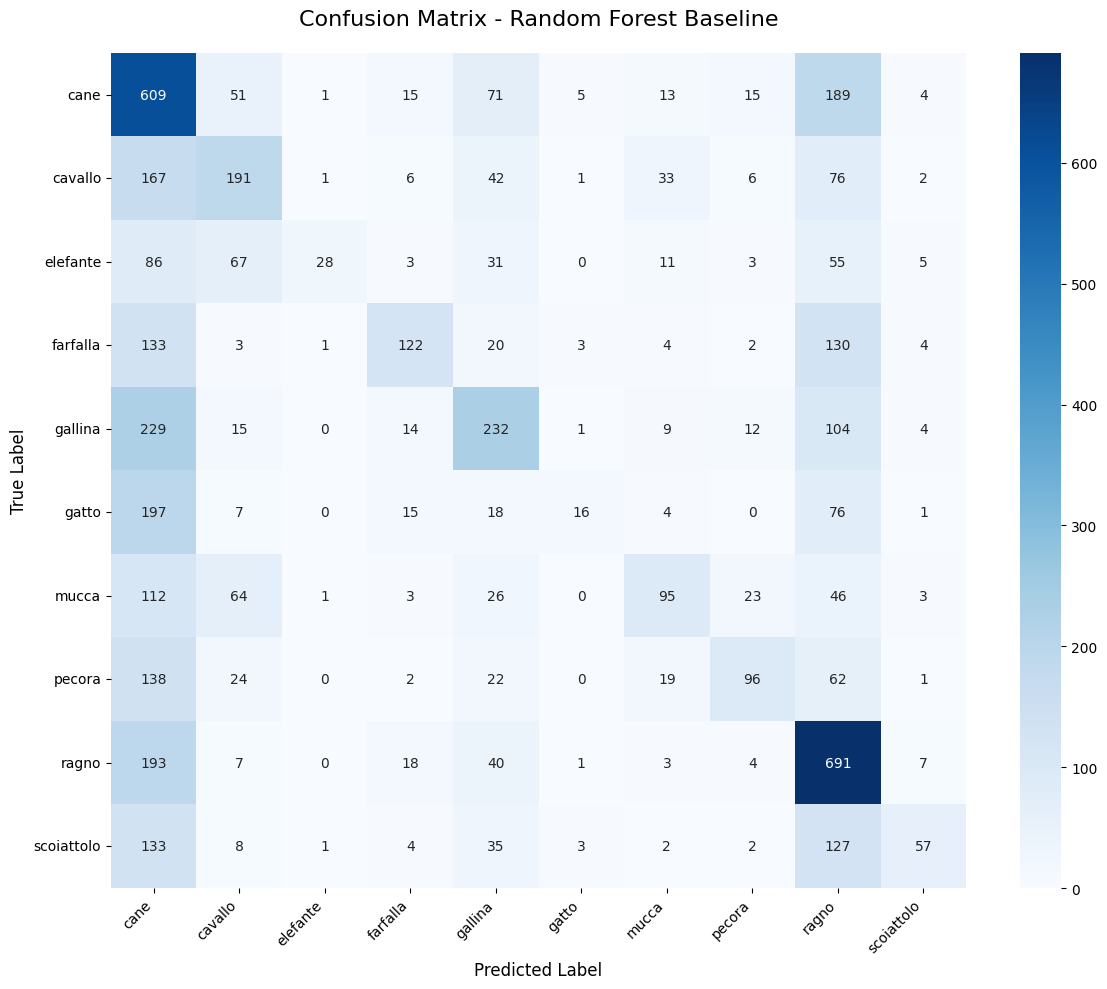

Confusion matrix saved


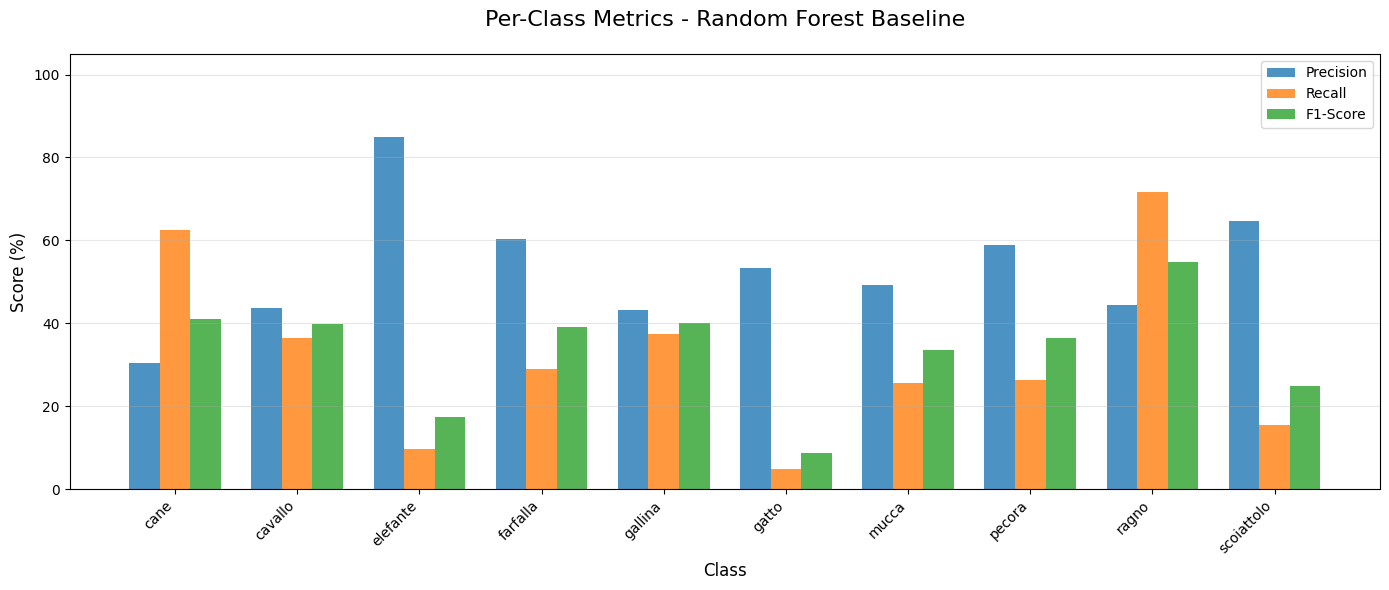

Per-class metrics plot saved

Results saved to rf_baseline_results/


In [24]:
# =============================================================================
# Evaluate the Model
# =============================================================================

# Ensure model is trained before evaluation. Train if scaler or RF not fitted.
if not hasattr(rf_baseline.scaler, "mean_") or not hasattr(rf_baseline.rf_model, "estimators_"):
	print("Scaler or RandomForest not fitted yet. Training the model now...")
	rf_baseline.train(X_train, y_train)
else:
	print("Model already trained. Skipping training step.")

# Evaluate and save results
metrics = rf_baseline.evaluate(X_test, y_test, save_path='rf_baseline_results')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


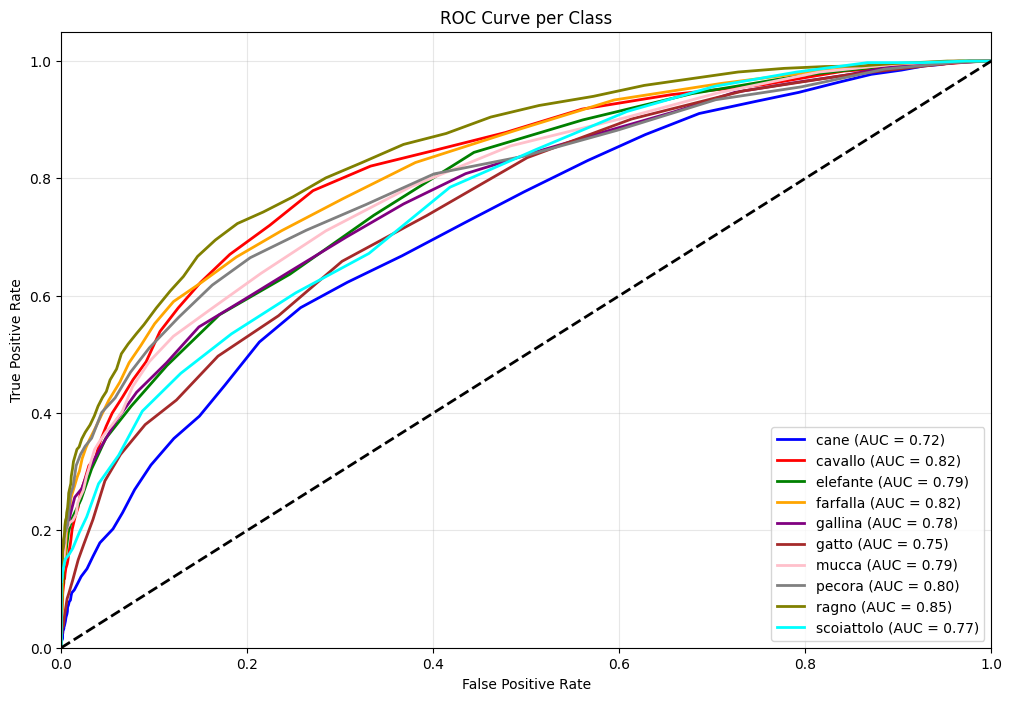

In [25]:
# =============================================================================
# ROC Curves and AUC
# =============================================================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def plot_multiclass_roc(model, X_test, y_test, class_names, scaler=None):
    n_classes = len(class_names)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # Get probabilities
    if scaler:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test

    y_score = model.predict_proba(X_test_scaled)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve per Class')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('roc_curves.png', dpi=300)
    plt.show()

# Run visualization (Use rf_baseline or rf_tuned)
plot_multiclass_roc(rf_baseline.rf_model, X_test, y_test, rf_baseline.class_names, rf_baseline.scaler)

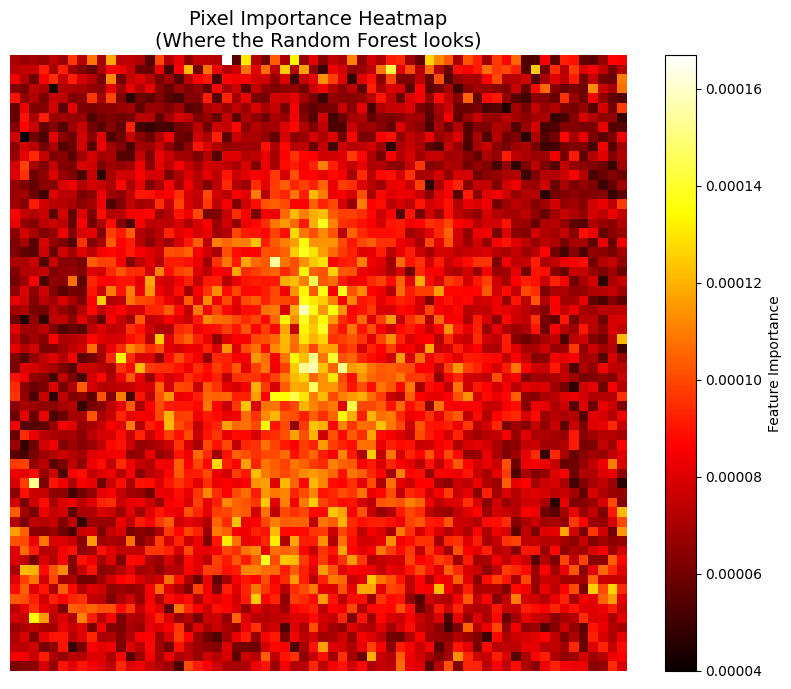

In [26]:
# =============================================================================
# Feature Importance Heatmap (Only for Raw Pixel Model)
# =============================================================================

def plot_pixel_importance(model, img_size):
    importances = model.feature_importances_
    
    # Reshape from (12288,) to (64, 64, 3)
    importances_img = importances.reshape(img_size[0], img_size[1], 3)
    
    # Average across RGB channels to get a single heatmap intensity
    heatmap = np.mean(importances_img, axis=2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Feature Importance')
    plt.title('Pixel Importance Heatmap\n(Where the Random Forest looks)', fontsize=14)
    plt.axis('off')
    plt.savefig('feature_importance_heatmap.png', dpi=300)
    plt.show()

# Note: Only run this on the baseline raw pixel model, not HOG
plot_pixel_importance(rf_baseline.rf_model, rf_baseline.img_size)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
/var/folders/4q/43_nrtbn36l6vhtn784k1pkw0000gn/T/ipykernel_17382/1759416138.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette='viridis')


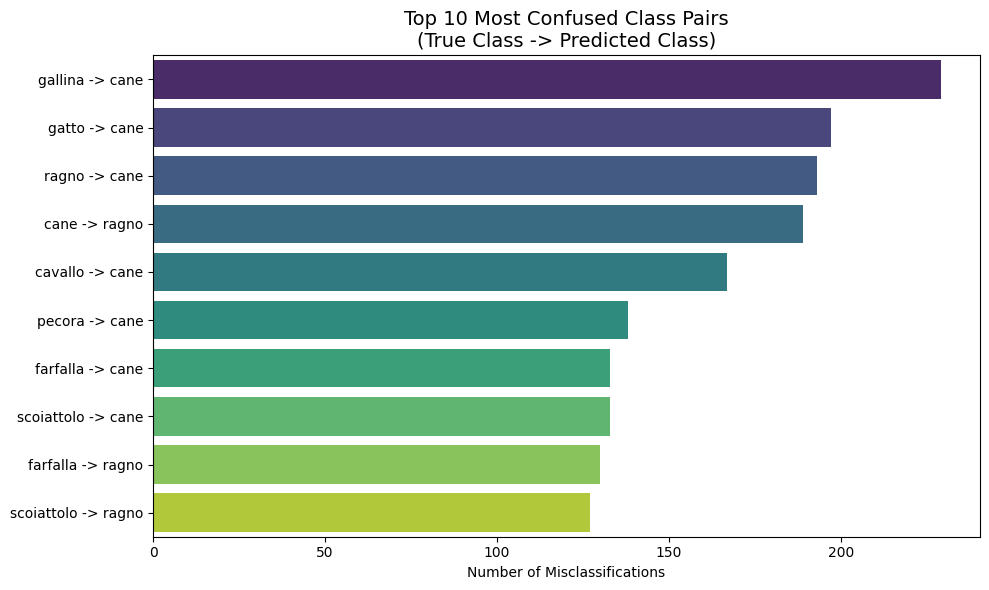

In [27]:
# =============================================================================
# Top Confusion Pairs Analysis
# =============================================================================

def plot_top_confusions(model, X_test, y_test, class_names, scaler):
    X_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_scaled)
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Zero out the diagonal (correct predictions) so we only find errors
    np.fill_diagonal(cm, 0)
    
    # Find top 5 confused pairs
    pairs = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if cm[i, j] > 0:
                pairs.append(((class_names[i], class_names[j]), cm[i, j]))
    
    # Sort by count descending
    pairs.sort(key=lambda x: x[1], reverse=True)
    top_pairs = pairs[:10]
    
    # Prepare data for plot
    labels = [f"{p[0]} -> {p[1]}" for p, c in top_pairs]
    counts = [c for p, c in top_pairs]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=labels, palette='viridis')
    plt.title('Top 10 Most Confused Class Pairs\n(True Class -> Predicted Class)', fontsize=14)
    plt.xlabel('Number of Misclassifications')
    plt.tight_layout()
    plt.savefig('top_confusions.png', dpi=300)
    plt.show()

plot_top_confusions(rf_baseline.rf_model, X_test, y_test, rf_baseline.class_names, rf_baseline.scaler)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


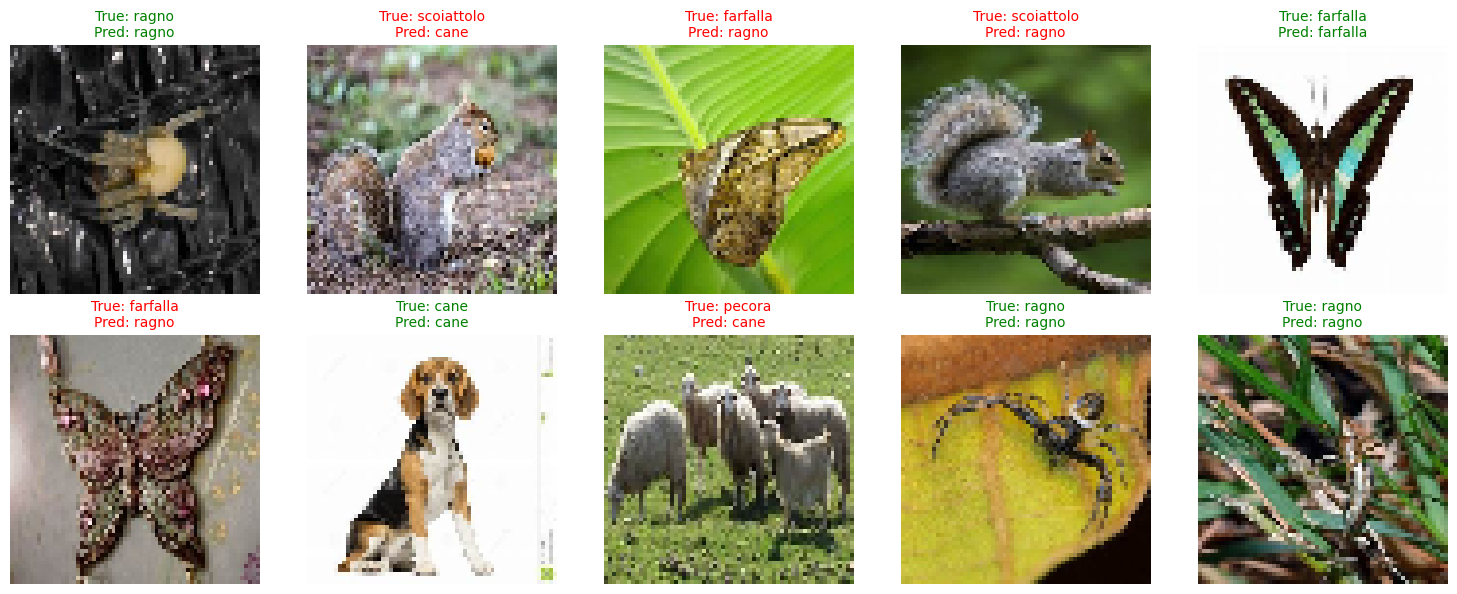

Sample predictions saved!


In [28]:
# =============================================================================
# Display Sample Predictions
# =============================================================================

# Optional: Show some sample predictions
def show_sample_predictions(rf_baseline, X_test, y_test, num_samples=10):
    """Display sample predictions"""

    # Get predictions
    X_test_scaled = rf_baseline.scaler.transform(X_test)
    y_pred = rf_baseline.rf_model.predict(X_test_scaled)

    # Random sample
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        # Reshape flattened image back to original shape
        img = X_test[idx].reshape(rf_baseline.img_size[0], rf_baseline.img_size[1], 3)

        axes[i].imshow(img)
        axes[i].axis('off')

        true_label = rf_baseline.class_names[y_test[idx]]
        pred_label = rf_baseline.class_names[y_pred[idx]]

        color = 'green' if y_test[idx] == y_pred[idx] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                         color=color, fontsize=10)

    plt.tight_layout()
    plt.savefig('rf_baseline_results/sample_predictions.png', dpi=200, bbox_inches='tight')
    plt.show()
    print("Sample predictions saved!")

# Run sample predictions
show_sample_predictions(rf_baseline, X_test, y_test, num_samples=10)

In [29]:
# =============================================================================
# Summary Statistics
# =============================================================================

# Print summary statistics
print("\n" + "="*60)
print("FINAL SUMMARY - RANDOM FOREST BASELINE")
print("="*60)
print(f"\nDataset Configuration:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Number of classes: {len(rf_baseline.class_names)}")
print(f"  Classes: {', '.join(rf_baseline.class_names)}")

print(f"\nModel Configuration:")
print(f"  Image size: {rf_baseline.img_size}")
print(f"  Feature dimension: {X_train.shape[1]}")
print(f"  Number of trees: {rf_baseline.n_estimators}")

print(f"\nPerformance Metrics:")
print(f"  Test Accuracy: {metrics['accuracy']*100:.2f}%")
print(f"  Macro Precision: {metrics['precision_macro']*100:.2f}%")
print(f"  Macro Recall: {metrics['recall_macro']*100:.2f}%")
print(f"  Macro F1-Score: {metrics['f1_macro']*100:.2f}%")
print(f"  Avg inference time: {metrics['avg_time_per_image_ms']:.2f} ms/image")

print("\n" + "="*60)


FINAL SUMMARY - RANDOM FOREST BASELINE

Dataset Configuration:
  Training samples: 17016
  Test samples: 5236
  Number of classes: 10
  Classes: cane, cavallo, elefante, farfalla, gallina, gatto, mucca, pecora, ragno, scoiattolo

Model Configuration:
  Image size: (64, 64)
  Feature dimension: 12288
  Number of trees: 100

Performance Metrics:
  Test Accuracy: 40.81%
  Macro Precision: 53.33%
  Macro Recall: 31.86%
  Macro F1-Score: 33.57%
  Avg inference time: 0.02 ms/image



In [30]:
# =============================================================================
# Save the Trained Model
# =============================================================================

rf_baseline.save_model(save_path='rf_baseline_models')

print("\n" + "="*50)
print("BASELINE CLASSIFICATION COMPLETE!")
print("="*50)
print("\nAll results saved in 'rf_baseline_results/' folder")
print("Model saved in 'rf_baseline_models/' folder")


Model saved to rf_baseline_models/

BASELINE CLASSIFICATION COMPLETE!

All results saved in 'rf_baseline_results/' folder
Model saved in 'rf_baseline_models/' folder
